# **Year 3 project - Optimising the stability of a catalyst**

**Link to github repository: : https://github.com/fahim-ah/Yr3-Project.git ** 

**Python import.csv required to run code. Available upon request**

**Data Loading + imports**

In [48]:
import pandas as pd     # pip install pandas
import matplotlib.pyplot as plt     # pip install matplotlib
from sklearn.cluster import KMeans      # pip install scikit-learn
from matminer.featurizers.conversions import StrToComposition       # pip install matminer
from pymatgen.ext.matproj import MPRester       # pip install pymatgen
from sklearn.linear_model import LinearRegression
from IPython.display import display     # pip install display
from mp_api.client import MPRester      # pip install mp-api
from pymatgen.analysis.pourbaix_diagram import PourbaixDiagram
from pymatgen.analysis.pourbaix_diagram import PourbaixPlotter

# Reading initial dataset & displaying
initial_df = pd.read_csv(r'Python import.csv')
display(initial_df)

,Catalyst Materials,Family,Substrate,"Operating Conditions (T, pH, potential)","Valence state, A","Valence state, B",Ionic radius A,Ionic radius B,ΔGOH*,ΔGO*,ΔGOOH*,Adsorption strength,Stable hours/cycles,"Tafel Slope, mV per decade","Overpotential at xx (nearby) current density vs RHE, V","Reaction (HER, HRR, OER, ORR)"
0,(Mn-Co-Ta-Sb)Ox,NaN,(Mn-Co-Ta-Sb)Ox loaded on FTO,1M H2SO4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 h @ 0.26 mA/cm2,-,0.55,OER
1,[Mo2S12]2-,Transition metal dichalcogenide,NaN,Acidic media,NaN,NaN,NaN,NaN,-,-,-,-0.05 eV (H),NaN,NaN,NaN,HER
2,1T-MoS2,NaN,Exfoliated 2D 1T phase molybdenum disulfide lo...,0.5 M H2SO4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Potential increased by ~100 mV after 2 h @10 m...,322,0.42,OER
3,AgAlO3,Perovskite,-,Alkaline media,3.0,3.0,0.710,0.468,2.18,4.63,5.1,NaN,NaN,NaN,1.82,OER
4,AgBiO3,Perovskite,-,Alkaline media,1.0,5.0,1.061,0.760,1.09,3.37,4.23,NaN,NaN,NaN,1.55,OER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,YTiO3,Perovskite,-,Alkaline media,3.0,3.0,0.988,0.670,1.49,3.97,4.61,NaN,NaN,NaN,1.54,OER
1008,YUO3,Perovskite,-,Alkaline media,3.0,3.0,0.988,1.025,0.81,2.59,4.09,NaN,NaN,NaN,1.72,OER
1009,YVO3,Perovskite,-,Alkaline media,3.0,3.0,0.988,0.640,0.61,1.7,3.9,NaN,NaN,NaN,1.34,OER
1010,YZnO3,Perovskite,-,Alkaline media,3.0,2.0,0.988,0.730,1.74,5.03,4.54,NaN,NaN,NaN,2.06,OER


**Data exploration**

In [49]:
#Funtion to explore the dataset, find column names, any null values etc...
def dataset_info(dataset):
    print(dataset.columns)
    print(dataset.describe())
    print(dataset.info())
    display(dataset)

**Data cleaning functions**

In [50]:
#This function will replace '-' values for zeroes. Also replace Nan values with zeroes
def parse_Nan(dataset):
    parse_datatset = dataset.replace('-',0) 
    parse_datatset = parse_datatset.fillna(0)
    return parse_datatset
#This function will count all the zeroes in the dataframe
def count_zeroes(df):
    return (df == 0).sum()

In [51]:
#This function will filter columns that are required for us. Also convert some object columns to floats
def column_cleaning(dataset):
    columns_to_keep = ["Catalyst Materials","Family","ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V","Reaction (HER, HRR, OER, ORR)"]
    updated_data = dataset.loc[:,columns_to_keep]
    columns_to_int = ["ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    updated_data[columns_to_int] = updated_data[columns_to_int].astype(float)
    return updated_data

**Launching cleaning functions on datasets + further exploration**

In [52]:
#Launching functions
initial_df = parse_Nan(initial_df)
zeroes_df = count_zeroes(initial_df)
display(zeroes_df) 
updated_data = column_cleaning(initial_df)

# Finding information on catalyst families and reaction types 
print(updated_data['Family'].value_counts())
print(updated_data['Reaction (HER, HRR, OER, ORR)'].value_counts())

Catalyst Materials                                           0
Family                                                      48
Substrate                                                  917
Operating Conditions (T, pH, potential)                     28
Valence state, A                                           206
Valence state, B                                           206
Ionic radius A                                             206
Ionic radius B                                             206
ΔGOH*                                                      180
ΔGO*                                                       180
ΔGOOH*                                                     180
Adsorption strength                                       1006
Stable hours/cycles                                        942
Tafel Slope, mV per decade                                 903
Overpotential at xx (nearby) current density vs RHE, V      53
Reaction (HER, HRR, OER, ORR)                          

Perovskite                                     826
0                                               48
Bimetallic oxide                                26
Noble metal                                     23
Transition metal dichalcogenide                 18
Noble metal oxide                               16
2D TMD, 2H                                       9
2D TMD, 1T                                       7
Transition metal phosphide                       4
Transition metal oxide                           4
Metal alloy oxide                                3
Transition metal chalcogenide                    3
Transition metal                                 2
Metal dicalcogenide                              2
Metal dichalcogenide                             2
Transition metal carbide, in carbon martix5      2
Transition metal phosphate                       2
Noble bimetallic alloy                           2
Metal oxide                                      2
Metal phosphate                

**Adding reaction pathway energy differences**

In [53]:
# Begin to compare the two reaction pathways to determine which one to use

updated_data['ΔGO*-ΔGOH*'] = updated_data['ΔGO*'] - updated_data['ΔGOH*']
updated_data['ΔGOOH*-ΔGO*'] = updated_data['ΔGOOH*'] - updated_data['ΔGO*']

#Slicing only data with values for required columns, then plotting dataset
updated_data = updated_data.loc[updated_data["ΔGO*-ΔGOH*"] != 0.0 ]

# .describe() will give the mean of both pathways, hence can determine which one to use
print(updated_data.describe())

            ΔGOH*        ΔGO*      ΔGOOH*  \
count  831.000000  831.000000  831.000000   
mean     0.863430    2.635584    4.055343   
std      0.896564    1.575981    0.749906   
min     -2.840000   -2.960000    0.830000   
25%      0.280000    1.610000    3.530000   
50%      0.880000    2.680000    4.070000   
75%      1.490000    3.785000    4.580000   
max      2.930000    5.800000    5.840000   

       Overpotential at xx (nearby) current density vs RHE, V  ΔGO*-ΔGOH*  \
count                                         831.000000       831.000000   
mean                                            1.385692         1.772154   
std                                             0.461869         0.805186   
min                                             0.260000        -0.700000   
25%                                             1.120000         1.275000   
50%                                             1.450000         1.760000   
75%                                             1.70000

**Element composition featurisation**

In [54]:
#Creating a column for element composition
str_comp = StrToComposition(target_col_id='composition')
updated_data = str_comp.featurize_dataframe(updated_data, col_id='Catalyst Materials')

StrToComposition: 100%|██████████| 831/831 [00:33<00:00, 25.15it/s] 


**Accessing material ID from material project + other properties**

In [55]:
'''
This block will use an API key to gather material information from The Materials Project
'formula='**O3'' gathers data for perovskites
Data of interest that was retrieved include material_id and chemsys
print(data_list) prints all the material properties possible to gather
'''

with MPRester('CmGarHKLtPCjVpEkivPDYkhRJKJiB8A7') as mpr:
    results = mpr.summary.search(formula='**O3', fields=["material_id", "formula_pretty",'band_gap','chemsys'])
    data_list = [(result.material_id, result.formula_pretty, result.band_gap,result.chemsys) for result in results]
    #print(data_list)

Retrieving SummaryDoc documents: 100%|██████████| 2544/2544 [00:01<00:00, 2484.61it/s]


In [56]:
'''
Some formulae imported from The Materials project was not in the correct format
e.g. AlGdO3 is in our dataset but in the API its given as GdAlO3
This occurs often and doesnt allow our dataset to merge with the imported data
Therefore this function rearranges the imported formulae to allow merge
'''
def alph_order(composition):
    new_formula = []
    for i in composition:
        first= []
        second= []
        temp = list(i)
        capital_pos=[]
        for x in range(0, len(temp)):
            if temp[x].isupper() == True:
                capital_pos.append(x)
        for y in range(capital_pos[0], capital_pos[1]):
                first.append(temp[y])
        for z in range(capital_pos[1], len(temp)):
                second.append(temp[z])
        first = ''.join(str(v) for v in first)
        second = ''.join(str(v) for v in second)
        compound = ''.join(str(v) for v in first)
        compound = second+first+"O3"
        new_formula.append(compound)
    return new_formula

#This function is to delete the extra O3 placed in the formulas

def remove_O3(composition):
    return [i.replace("O3", "") for i in composition]

def add_o3(composition):
    return [i + "O3" for i in composition]



**Sorting list to a dictionary**

In [57]:
'''
Imported data is given as a list 
This block converts list into a dictionary format
After dictionary is produced it is made into a pandas dataframe
'''

formula = []
material_id = []
band_gap = []
chemsys = []
for i in data_list:
    material_id.append(i[0])
    formula.append(i[1])
    band_gap.append(i[2])
    chemsys.append(i[3])
#Creating dictionary
material_proj_data = dict((z[0], list(z[1:])) for z in zip(formula, material_id, band_gap, chemsys))
rearranged_formula = alph_order(formula)
rearranged_formula = remove_O3(rearranged_formula)
rearranged_formula = add_o3(rearranged_formula)
#Creating dictionary for re-arranged formulae
material_proj_data_rearranged = dict((z[0], list(z[1:])) for z in zip(rearranged_formula, material_id, band_gap, chemsys))
material_proj_data.update(material_proj_data_rearranged)

**Dictionary to pandas dataframe + merge with original dataset**

In [58]:
#Merging imported data to our dataset

material_proj_df = pd.DataFrame.from_dict(material_proj_data, orient= 'index')
material_proj_df = material_proj_df.reset_index()
material_proj_df.columns = ["Catalyst Materials", "material id", "band gap","chemsys"]
updated_data = updated_data.merge(material_proj_df, on ='Catalyst Materials', how= 'left')

**Dataset exploration after importing data**

In [59]:
# Exploring data after importing new properties

dataset_info(updated_data)

Index(['Catalyst Materials', 'Family', 'ΔGOH*', 'ΔGO*', 'ΔGOOH*',
       'Overpotential at xx (nearby) current density vs RHE, V',
       'Reaction (HER, HRR, OER, ORR)', 'ΔGO*-ΔGOH*', 'ΔGOOH*-ΔGO*',
       'composition', 'material id', 'band gap', 'chemsys'],
      dtype='object')
            ΔGOH*        ΔGO*      ΔGOOH*  \
count  831.000000  831.000000  831.000000   
mean     0.863430    2.635584    4.055343   
std      0.896564    1.575981    0.749906   
min     -2.840000   -2.960000    0.830000   
25%      0.280000    1.610000    3.530000   
50%      0.880000    2.680000    4.070000   
75%      1.490000    3.785000    4.580000   
max      2.930000    5.800000    5.840000   

       Overpotential at xx (nearby) current density vs RHE, V  ΔGO*-ΔGOH*  \
count                                         831.000000       831.000000   
mean                                            1.385692         1.772154   
std                                             0.461869         0.805186   
min

,Catalyst Materials,Family,ΔGOH*,ΔGO*,ΔGOOH*,"Overpotential at xx (nearby) current density vs RHE, V","Reaction (HER, HRR, OER, ORR)",ΔGO*-ΔGOH*,ΔGOOH*-ΔGO*,composition,material id,band gap,chemsys
0,AgAlO3,Perovskite,2.18,4.63,5.10,1.82,OER,2.45,0.47,"(Ag, Al, O)",mp-1343327,0.0481,Ag-Al-O
1,AgBiO3,Perovskite,1.09,3.37,4.23,1.55,OER,2.28,0.86,"(Ag, Bi, O)",mp-23548,0.0000,Ag-Bi-O
2,AgCoO3,Perovskite,1.59,3.28,4.66,0.92,OER,1.69,1.38,"(Ag, Co, O)",mp-1273356,0.0000,Ag-Co-O
3,AgCrO3,Perovskite,0.83,2.36,4.26,1.31,OER,1.53,1.90,"(Ag, Cr, O)",NaN,NaN,NaN
4,AgCuO3,Perovskite,1.80,4.36,4.79,1.38,OER,2.56,0.43,"(Ag, Cu, O)",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,YTaO3,Perovskite,-0.34,1.06,3.24,1.96,OER,1.40,2.18,"(Y, Ta, O)",NaN,NaN,NaN
827,YTiO3,Perovskite,1.49,3.97,4.61,1.54,OER,2.48,0.64,"(Y, Ti, O)",mp-1443298,0.0000,O-Ti-Y
828,YUO3,Perovskite,0.81,2.59,4.09,1.72,OER,1.78,1.50,"(Y, U, O)",NaN,NaN,NaN
829,YVO3,Perovskite,0.61,1.70,3.90,1.34,OER,1.09,2.20,"(Y, V, O)",mp-1375509,1.1014,O-V-Y


**Preparing first graph**

In [60]:
'''
This function will plot the scatter plot for 'ΔGO*-ΔGOH*' against overpotential
Plots for ΔGO* & ΔGOH* were produced to explore any anomalous data that could have occured
'''

def plot_scatter_reaction_path(data):
    x_variables = ['ΔGO*-ΔGOH*','ΔGO*','ΔGOH*']
    for i in x_variables:
        plt.scatter(data[i],data["Overpotential at xx (nearby) current density vs RHE, V"])
        plt.xlabel(i+'(eV)')
        plt.ylabel('Overpotential at xx (nearby) current density vs RHE (V)')
        if i=='ΔGO*-ΔGOH*':
            plt.title('Plot for overpotential against reaction pathway')
            plt.savefig('Scatter_plots\Overpotential against reaction step (GO-GOH).png',bbox_inches='tight')
        elif i=='ΔGO*':
            plt.savefig('Scatter_plots\Overpotential against reaction step (GO).png',bbox_inches='tight')
        else:
            plt.savefig('Scatter_plots\Overpotential against reaction step (GOH).png',bbox_inches='tight')
        plt.show()

**Clustering**

In [61]:
#Creating an elbow plot to determine how many cluster will be required for model

def elbow_plot(elbow_data):
    k_rng = range(1,10)
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters= k)
        km.fit(elbow_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
        sse.append(km.inertia_)     # Calculates SSE for each cluster
    print(sse)
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Sum of squared error')
    plt.title('Elbow plot for SSE against number of clusters')
    plt.plot(k_rng,sse)
    plt.savefig('Scatter_plots\Elbow plot .png',bbox_inches='tight')
    plt.show()

In [62]:
#Creating cluster plot using K-means method
def cluster_df(cluster_df,n_clusters):
    color = ['black','green','purple','red','blue']
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*-ΔGOH*'],data["Overpotential at xx (nearby) current density vs RHE, V"],c=color[k])
        # Save datasets
        if k==0:
            data.to_csv('Cluster_csv_files\Cluster_0.csv')
        elif k==1:
                data.to_csv('Cluster_csv_files\Cluster_1.csv')
        elif k==2:
            data.to_csv('Cluster_csv_files\Cluster_2.csv')
        elif k==3:
            data.to_csv('Cluster_csv_files\Cluster_3.csv')
        else:
            data.to_csv('Cluster_csv_files\Cluster_4.csv')
    plt.xlabel('ΔGO*-ΔGOH* (eV)')
    plt.ylabel('Overpotential at xx (nearby) current density vs RHE (V)')
    plt.title('Plot for overpotential against reaction pathway [CLUSTERED]')
    plt.savefig('Scatter_plots\Overpotential against reaction step (with regions).png',bbox_inches='tight')
    plt.show()

    #Creates the same clusters in the linear regression models
    
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGOH*'],data['ΔGOOH*'],c=color[k])
    plt.xlabel('ΔGOH* (eV)')
    plt.ylabel('ΔGOOH* (eV)')
    plt.title('Linear relationship between OH* & OOH*')
    plt.savefig('Scatter_plots\GOH against GOOH .png',bbox_inches='tight')
    plt.show()
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*'],data['ΔGOH*'],c=color[k])
    plt.xlabel('ΔGO* (eV)')
    plt.ylabel('ΔGOH* (eV)')
    plt.title('Linear relationship between O* & OH*')
    plt.savefig('Scatter_plots\GO against GOH .png',bbox_inches='tight')
    plt.show()
    

In [86]:
# Code to form linear regression model
def linear_regression_model(dataset,x,y):
    reg = LinearRegression()
    reg.fit(dataset[[x]], dataset[[y]])
    slope = reg.coef_[0][0]     # Calculates gradient of linear regression
    print(slope)    

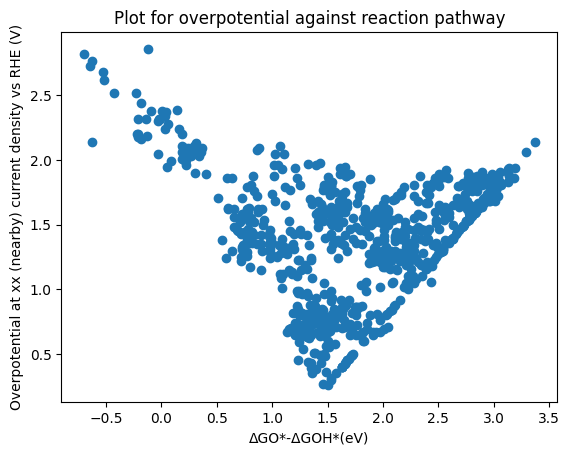

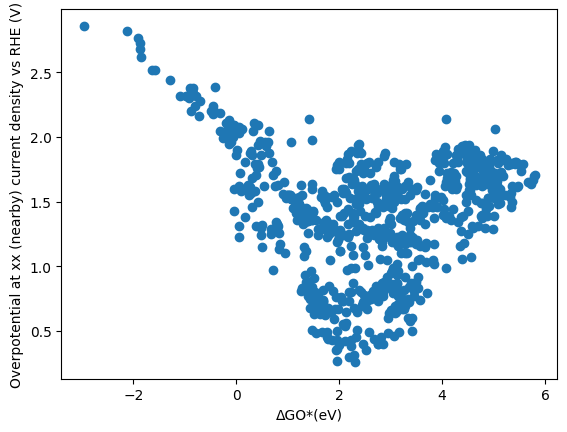

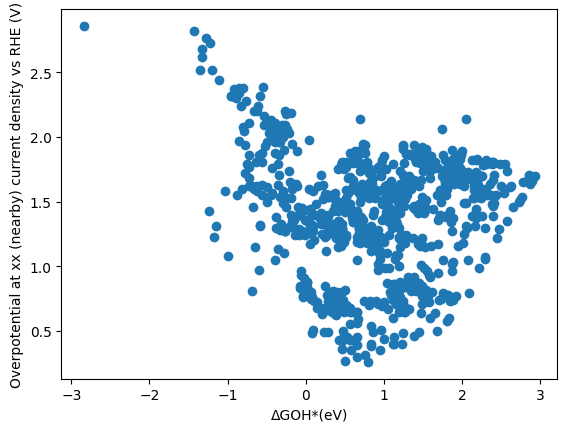

[715.1674214199759, 351.57047329051386, 198.41676449655822, 132.10847541638904, 82.57814484071653, 61.33481627170051, 54.386390274477236, 47.99095799210361, 43.49329230436147]


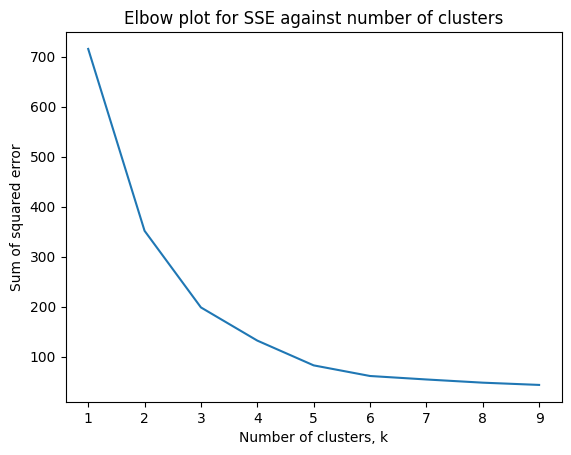

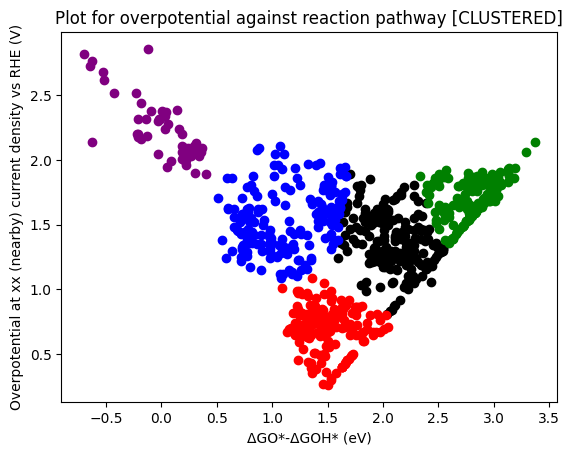

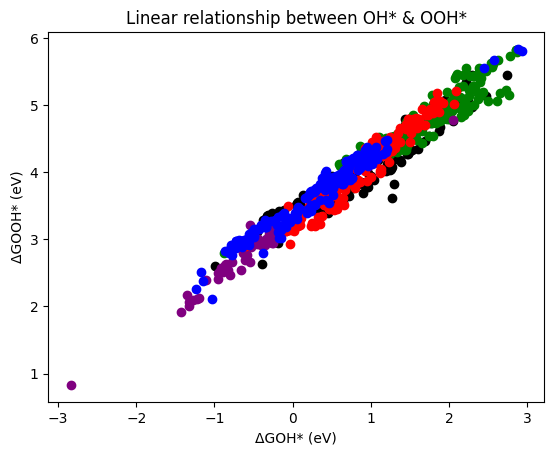

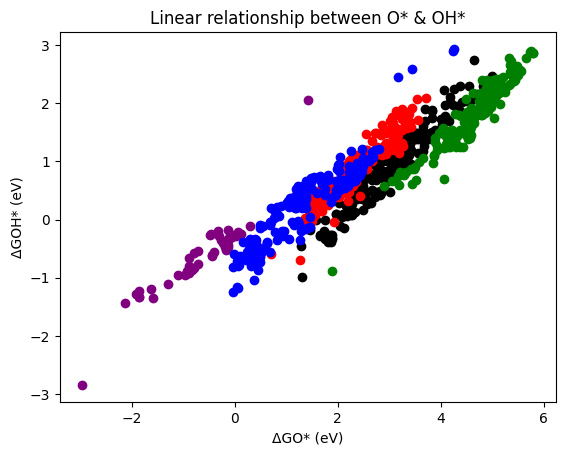

0.8164515758533752
0.5313043087091569


In [87]:
#Placing functions down
plot_scatter_reaction_path(updated_data)
elbow_plot(updated_data)
km = KMeans(n_clusters= 5)
y_predicted = km.fit_predict(updated_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
updated_data['cluster'] = y_predicted
cluster_df(updated_data,5)
linear_regression_model(updated_data,'ΔGOH*','ΔGOOH*')
linear_regression_model(updated_data,'ΔGO*','ΔGOH*')

# **Exploring data for each cluster**

**Re-importing cluster dataframes**

In [65]:
# Importing all datasets and saving to a variable
cluster_1 = pd.read_csv(r'Cluster_csv_files\Cluster_0.csv')
cluster_2 = pd.read_csv(r'Cluster_csv_files\Cluster_1.csv')
cluster_3 = pd.read_csv(r'Cluster_csv_files\Cluster_2.csv')
cluster_4 = pd.read_csv(r'Cluster_csv_files\Cluster_3.csv')
cluster_5 = pd.read_csv(r'Cluster_csv_files\Cluster_4.csv')

**Determining which cluster is assigned**

In [66]:
'''Function to find minimum overpotential in a dataset
The minimum will be used to keep a cluster variable consistent for the rest of the project
This is because the cluster value changes every time the code is run
'''
def print_min(data):
    print(data["Overpotential at xx (nearby) current density vs RHE, V"].min())
print_min(cluster_1)
print_min(cluster_2)
print_min(cluster_3)
print_min(cluster_4)
print_min(cluster_5)
df_list = [cluster_1,cluster_2,cluster_3,cluster_4,cluster_5]

1.36
0.26
1.89
1.09
0.81


In [67]:
# Assigning clusters

def assign_clusters(df_list):
    for data in df_list:
        if data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 1.89:
            left_data = data
        elif data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 1.09:
            middle_left = data
        elif data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 0.81:
            middle_right = data
        elif data["Overpotential at xx (nearby) current density vs RHE, V"].min() == 0.26:
            optimum_region = data
        else:
            right_data = data
    new_df_list = [left_data,middle_left,middle_right,optimum_region,right_data]
    return new_df_list

new_df_list = assign_clusters(df_list)

var_names = ["left_data", "middle_left", "middle_right", "optimum_region", "right_data"]
vars_dict = dict(zip(var_names, new_df_list))
left_data = vars_dict["left_data"]
middle_left= vars_dict["middle_left"]
middle_right = vars_dict["middle_right"]
optimum_region = vars_dict["optimum_region"]
right_data = vars_dict["right_data"]

In [68]:
#Making a spreadsheet for each cluster region

with pd.ExcelWriter('separated regions.xlsx') as writer:  
    left_data.to_excel(writer, sheet_name='left data')
    middle_right.to_excel(writer, sheet_name='middle right')
    middle_left.to_excel(writer, sheet_name='middle left')
    optimum_region.to_excel(writer, sheet_name='optimum region')
    right_data.to_excel(writer, sheet_name='right data')

**Finding composition data on each dataframe**

In [69]:
#Function to produce a df of counts for every element within each region

def retrieve_composition_df(df):
    comp_list = list(df['composition'])
    ind_element = []
    for i in comp_list:
        ind_element+=i.split()
    [[x,ind_element.count(x)] for x in set(ind_element)]
    ind_element_dic =  dict((x,ind_element.count(x)) for x in set(ind_element))
    ind_element_df = pd.DataFrame.from_dict(ind_element_dic, orient = 'index', columns=['Count'])
    ind_element_df= ind_element_df.reset_index(names=['Element'])
    ind_element_df = ind_element_df.sort_values(by = 'Count', ascending=False, ignore_index=True)
    return ind_element_df


In [70]:
#Bar chart plot to visualise the number of elements in each region, + saving figures

def bar_chart_element_count(df1,df2,df3,df4,df5):
    df_list = [df1,df2,df3,df4,df5]
    for i in range(0,len(df_list)):
        title_lst = ['Optimum region','Left side','Middle left','Middle right', 'Right side']
        df = df_list[i].loc[1:12,:]
        df = df[df.Element != 'O2']
        fig, ax = plt.subplots()
        ax.bar(x=df['Element'], height=df['Count'])
        ax.set_title(title_lst[i])
        ax.set_xlabel('Element')
        ax.set_ylabel('Count')
        fig.savefig('Bar_charts\\'+title_lst[i]+'.png', bbox_inches='tight')


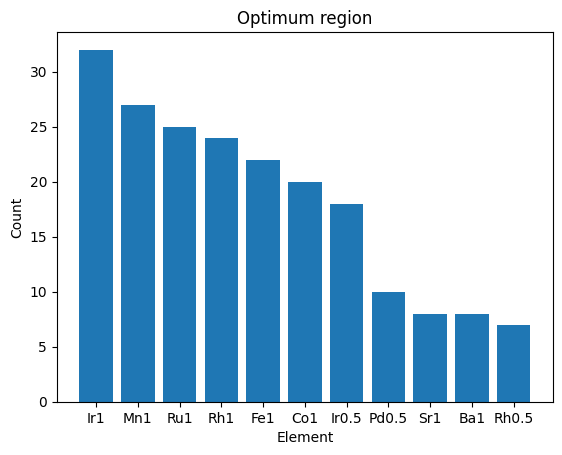

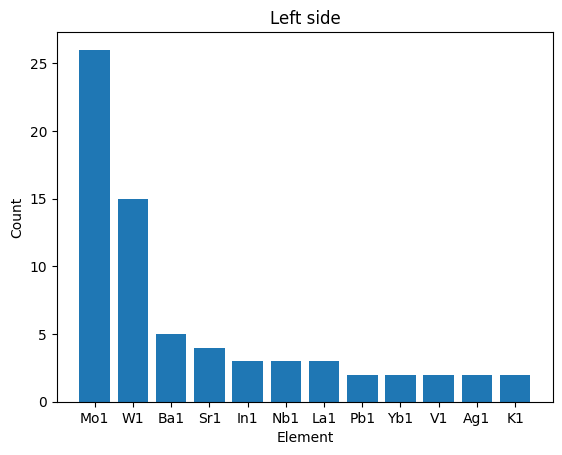

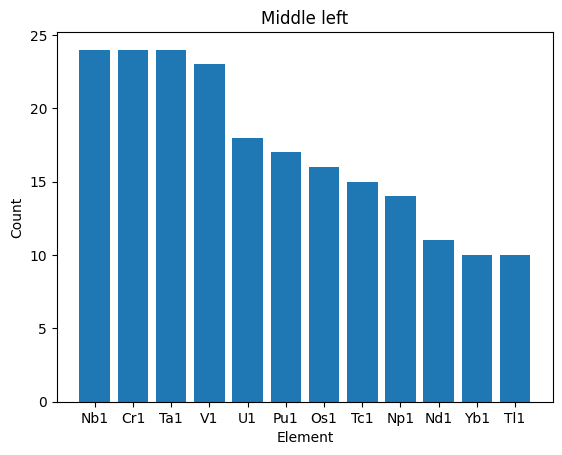

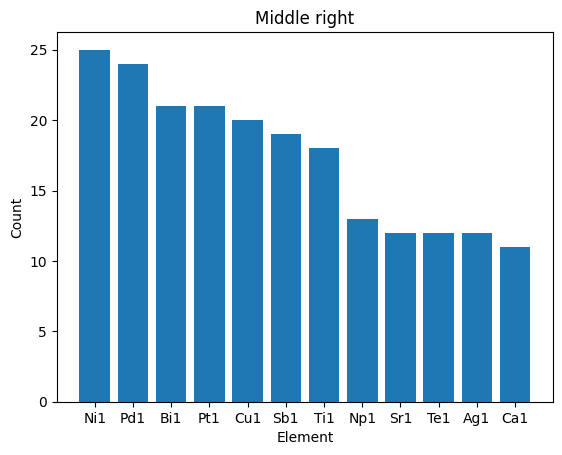

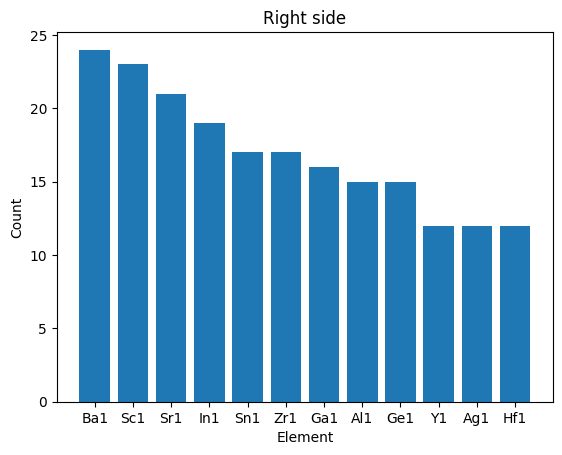

In [88]:
# Launching the two functions from above

element_df_optimum =  retrieve_composition_df(optimum_region)
element_df_left =  retrieve_composition_df(left_data)
element_df_middle_left =  retrieve_composition_df(middle_left)
element_df_middle_right =  retrieve_composition_df(middle_right)
element_df_right =  retrieve_composition_df(right_data)
bar_chart_element_count(element_df_optimum,element_df_left,element_df_middle_left,element_df_middle_right,element_df_right)

**Analysing if elements are spread or concentrated in one region**

In [72]:
# The following blocks will create a new excel spreadsheet which counts each element in every region (Appendix 3 in report)

#Adding new column names
title_lst = ['Optimum region','Left side','Middle left','Middle right', 'Right side']
element_df_optimum['Region'] = 'Optimum region'
element_df_left['Region'] = 'Left side'
element_df_middle_left['Region'] =  'Middle left'
element_df_middle_right['Region'] = 'Middle right'
element_df_right['Region'] = 'Right side'

In [73]:
#Combining datasets 
combined_element_df = pd.concat([element_df_optimum,element_df_left,element_df_middle_left,element_df_middle_right,element_df_right])
combined_element_df = combined_element_df.pivot_table(
                        values='Count',
                        index='Element',
                        columns='Region',
                        fill_value=0,
                        aggfunc= sum,
                        margins=True)
combined_element_df.to_excel('Element analysis file.xlsx')

In [74]:
# Function to remove rows which will not get us data from the materials project
# If the material does not have a material id, a pourbaix diagram cannot be generated
def remove_rows_without_data(datset):
    df = datset.dropna(subset = ['material id'], inplace = False)
    return df
df_list = [optimum_region,middle_left,middle_right,left_data,right_data]
left_data_pourbaix = remove_rows_without_data(left_data)
right_data_pourbaix = remove_rows_without_data(right_data)
middle_left_pourbaix = remove_rows_without_data(middle_left)
middle_right_pourbaix = remove_rows_without_data(middle_right)
optimum_region_pourbaix = remove_rows_without_data(optimum_region)

**Code for Generating pourbaix diagrams**

In [75]:
# A repeatable function to generate a pourbaix diagram
# Input equals to the chemical composition and a path to save the figure

def generate_pourbaix(chemsys,path):
    with MPRester(api_key='CmGarHKLtPCjVpEkivPDYkhRJKJiB8A7') as mpr:
        pourbaix_entries = mpr.get_pourbaix_entries(chemsys)
    pd = PourbaixDiagram(pourbaix_entries)
    plotter = PourbaixPlotter(pd)
    PourbaixPlotter.get_pourbaix_plot(plotter,limits=[[-2, 16],[-3, 3]]) # Typical value for lower = -2, upper = 16
    plt.savefig(path+chemsys+'.png',bbox_inches='tight')

**Gathering 10 random samples from each region**

In [76]:
'''Finding 10 random formulas from each region
   Uncomment following lines to generate new random samples from each region
'''
# rand_opt_region = random.sample(list(optimum_region_pourbaix['chemsys']), 10)
# rand_middle_left = random.sample(list(middle_left_pourbaix['chemsys']), 10)
# rand_middle_right = random.sample(list(middle_right_pourbaix['chemsys']), 10)
# rand_left = random.sample(list(left_data_pourbaix['chemsys']), 10)
# rand_right = random.sample(list(right_data_pourbaix['chemsys']), 10)


# Random samples generated when running the above code for the first time 
rand_opt_region = ['Cd-Mn-O', 'O-Rh-Tb', 'Lu-Mn-O', 'Fe-Lu-O', 'La-O-Ti', 'Ba-Mn-O', 'Cr-O-Sr', 'Ca-O-Ru', 'Mn-Nd-O', 'Fe-Nd-O']
rand_middle_left = ['Cr-Ho-O', 'O-Pb-V', 'Na-O-Pu', 'Dy-O-V', 'K-O-Os', 'Nb-O-Yb', 'La-O-Ta', 'O-Sm-V', 'Cd-O-V', 'K-O-Ta']
rand_middle_right = ['Bi-Ho-O', 'Ba-Bi-O', 'Ho-Ni-O', 'Cu-La-O', 'Au-Ba-O', 'Cs-I-O', 'Lu-Ni-O', 'Al-O-Yb', 'Dy-Ni-O', 'Ba-Cu-O']
rand_left = ['Ba-Mo-O', 'In-O-Ta', 'Na-O-W', 'Ca-O-W', 'Al-Ba-O', 'O-Tl-W', 'Ba-Nb-O', 'O-Sc-Si', 'Mo-Na-O', 'O-Sr-V']
rand_right = ['Al-Gd-O', 'Ba-O-Zr', 'O-Sr-Ti', 'O-Sc-Yb', 'Ba-O-Sc', 'In-Nd-O', 'Cu-O-Y', 'O-Pb-Sr', 'Eu-Ge-O', 'Ba-In-O']

#Function to generate pourbaix diagrams through each list
def list_screening(lst,index):
    path_name = ['Pourbaix_plots\Optimum_region\\','Pourbaix_plots\Middle_left\\','Pourbaix_plots\Middle_right\\',
                'Pourbaix_plots\Left_data\\','Pourbaix_plots\Right_data\\']
    for i in range(0,len(lst)):
        generate_pourbaix(lst[i],path_name[index])

In [77]:
# Generating pourbaix diagrams for random elements selected

list_screening(rand_opt_region,0)
list_screening(rand_middle_left,1)
list_screening(rand_middle_right,2)
list_screening(rand_left,3)
list_screening(rand_right,4)

**Comparing single element pourbaix to multi element**

In [78]:
# This cell will focus on the effects of noble metals

generate_pourbaix('Ag-Ru-O','Pourbaix_plots\Comapring_single_and_multi\\')
generate_pourbaix('Ag-Ru','Pourbaix_plots\Comapring_single_and_multi\\')
generate_pourbaix('Ag','Pourbaix_plots\Comapring_single_and_multi\\')
generate_pourbaix('Ag-O','Pourbaix_plots\Comapring_single_and_multi\\')
generate_pourbaix('Ru','Pourbaix_plots\Comapring_single_and_multi\\')
generate_pourbaix('Ru-O','Pourbaix_plots\Comapring_single_and_multi\\')


In [79]:
# This cell will focus on the effects of lanthanides

generate_pourbaix('Fe-Nd-O','Pourbaix_plots\Comapring_single_and_multi\\')
generate_pourbaix('Fe-Nd','Pourbaix_plots\Comapring_single_and_multi\\')
generate_pourbaix('Fe','Pourbaix_plots\Comapring_single_and_multi\\')
generate_pourbaix('Fe-O','Pourbaix_plots\Comapring_single_and_multi\\')
generate_pourbaix('Nd','Pourbaix_plots\Comapring_single_and_multi\\')
generate_pourbaix('Nd-O','Pourbaix_plots\Comapring_single_and_multi\\')


**Lanthanide series analysis**

In [80]:
# This block will generate the lanthanide pourbaix diagrams for the whole series.

# List of lanthanides
lanth_list = ['Ce','Dy', 'Er', 'Eu', 'Gd', 'Ho', 'La', 'Lu', 'Nd', 'Pr', 'Sm', 'Tb', 'Tm', 'Yb']

# Looping over list and generating pourbaix diagram
for i in range(0,len(lanth_list)):
    generate_pourbaix(lanth_list[i],'Pourbaix_plots\Lanthanides\\')
